In [22]:
import pickle
import keras 
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Activation,Dropout
import keras.losses
import time
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf 
import pandas as pd
import numpy as np

In [2]:
X_train = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/X_train_new.pkl','rb'))
Y_train = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/Y_train_new.pkl','rb'))
X_test = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/X_test_new.pkl','rb'))
Y_test = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/Y_test_new.pkl','rb'))
X_val = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/X_val_new.pkl','rb'))
Y_val = pickle.load(open('/data/data_science/data/image_banned/DataProcessing/Y_val_new.pkl','rb'))

In [3]:
X_train = X_train.astype("float") / 255.0
X_val = X_val.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0

In [4]:
Y_train = keras.utils.np_utils.to_categorical(Y_train)
Y_val = keras.utils.np_utils.to_categorical(Y_val)

In [5]:
IMG_SIZE = 128

In [6]:
model = Sequential()
width = 128
height = 128
classes = 2

2021-08-20 23:47:08.811337: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-20 23:47:08.811456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MICZONE-ML03): /proc/driver/nvidia/version does not exist


In [7]:
shape = (width, height, 3)

In [8]:
model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.3))
model.add(Dense(classes))
model.add(Activation("softmax"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      1

In [10]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

In [11]:
model.compile(optimizer='adam',
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

In [12]:
csv_logger = keras.callbacks.CSVLogger("/data/data_science/data/image_banned/Result/log_4.csv",separator=',',append=True)

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data =(X_val,Y_val),batch_size=32,verbose = 1,use_multiprocessing=True,workers = 20,callbacks=(csv_logger))

2021-08-20 23:47:27.345381: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37164613632 exceeds 10% of free system memory.
2021-08-20 23:48:01.794639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1027/5908 [====>.........................] - ETA: 1:21:45 - loss: 4.5305 - accuracy: 0.7162

In [ ]:
model.save("/data/data_science/data/image_banned/Result/model_4.h5")

In [16]:
print("done")

done


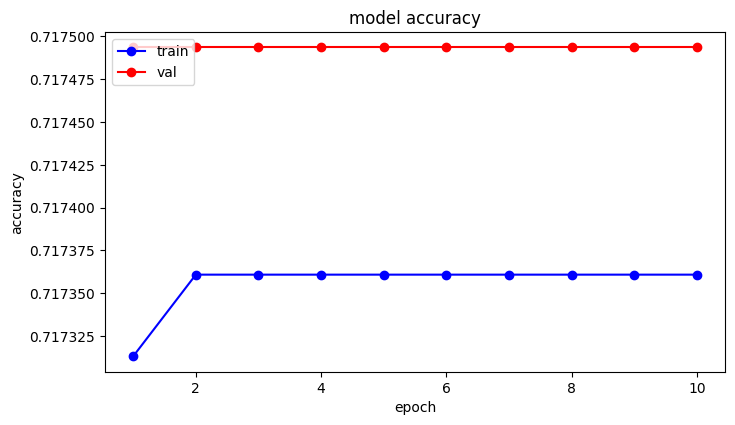

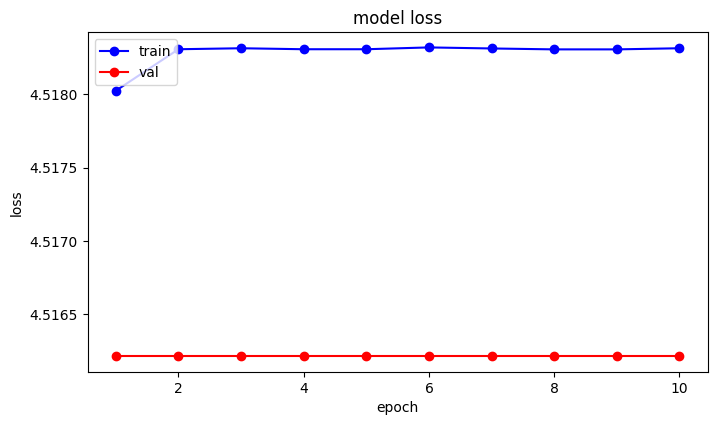

In [21]:
epoch = np.arange(1,11)
plt.figure(figsize = (8,4.5),dpi=100)
plt.plot(epoch,history.history['accuracy'],"-",color="b",label='train_accuracy',marker="o")
plt.plot(epoch,history.history['val_accuracy'],"-",color="r",label="val_accuracy",marker="o")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize = (8,4.5),dpi=100)
plt.plot(epoch,history.history['loss'],"-",color="b",label="train_loss",marker="o")
plt.plot(epoch,history.history['val_loss'],"-",color="r",label="val_loss",marker="o")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
pred = model.predict(X_test)
pred_idx = np.argmax(pred, axis=1)

In [24]:
print(classification_report(Y_test, pred_idx))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16439
           1       0.72      1.00      0.84     41734

    accuracy                           0.72     58173
   macro avg       0.36      0.50      0.42     58173
weighted avg       0.51      0.72      0.60     58173



/data/data_science/project/quang_jupyter/vendors/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/data_science/project/quang_jupyter/vendors/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/data_science/project/quang_jupyter/vendors/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-d

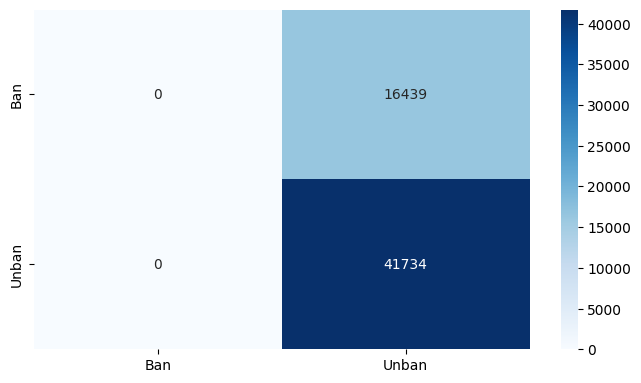

In [25]:
cm = confusion_matrix(Y_test,pred_idx)
df_cm = pd.DataFrame(cm, index=['Ban',"Unban"], columns=['Ban',"Unban"])
plt.figure(figsize = (8,4.5),dpi=100)
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='d')
plt.show()